# q2


In [ ]:
from google.colab import drive

drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
!unzip /content/gdrive/MyDrive/household_power_consumption.zip

Archive:  /content/gdrive/MyDrive/household_power_consumption.zip
replace household_power_consumption.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


# 80:20


In [ ]:
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv('household_power_consumption.txt', delimiter=';', 
                 parse_dates={'DateTime' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'])

# Drop rows with missing values
df.dropna(inplace=True)

# Convert data types of relevant columns
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], downcast='float')
df['Global_reactive_power'] = pd.to_numeric(df['Global_reactive_power'], downcast='float')
df['Voltage'] = pd.to_numeric(df['Voltage'], downcast='float')
df['Global_intensity'] = pd.to_numeric(df['Global_intensity'], downcast='float')



# Print the first few rows of the preprocessed DataFrame
df.head()

,DateTime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.839996,18.4,0.0,1.0,17.0
1,2006-12-16 17:25:00,5.360,0.436,233.630005,23.0,0.0,1.0,16.0
2,2006-12-16 17:26:00,5.374,0.498,233.289993,23.0,0.0,2.0,17.0
3,2006-12-16 17:27:00,5.388,0.502,233.740005,23.0,0.0,1.0,17.0
4,2006-12-16 17:28:00,3.666,0.528,235.679993,15.8,0.0,1.0,17.0


In [ ]:
df.set_index('DateTime', inplace=True)

In [ ]:
import matplotlib.pyplot as plt


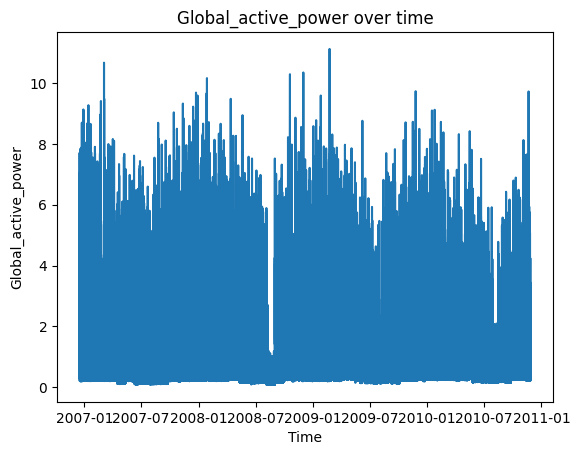

In [ ]:
plt.plot(df.Global_active_power)
plt.xlabel("Time")
plt.ylabel("Global_active_power")
plt.title("Global_active_power over time")
plt.savefig("initial_plot.png", dpi=1000)
plt.show();

In [ ]:
window_size=5

In [ ]:
def df_to_X_y2(df, window_size=6):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size][0]
    y.append(label)
  return np.array(X), np.array(y)

In [ ]:
X1, y1 = df_to_X_y2(df,window_size)
X1.shape, y1.shape

((2049275, 5, 7), (2049275,))

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()

#X_trans = ss.fit_transform(X1)
y1 = mm.fit_transform(y1.reshape(-1, 1))

In [ ]:
temp_training_mean = np.mean(X1[:, :, 0])
temp_training_std = np.std(X1[:, :, 0])
X1[:, :, 0] = (X1[:, :, 0] - temp_training_mean) / temp_training_std

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, data, targets):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.float32)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        return x, y

def numpy_to_dataset(data, targets):
    dataset = MyDataset(data, targets)
    #dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataset

In [ ]:
train = numpy_to_dataset(X1[:int(len(X1)*0.8)], y1[:int(len(X1)*0.8)])
test= numpy_to_dataset(X1[int(len(X1)*0.8):], y1[int(len(X1)*0.8):])

In [ ]:
batch_size = 64
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

y = y.view(-1)

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([64, 5, 7])
Target shape: torch.Size([64])


In [ ]:
from torch import nn

class ShallowRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.lstm = nn.LSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()

        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0]).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        return out

In [ ]:
class LSTM1(nn.Module):
    def __init__(self, num_sensors, hidden_units):
        super().__init__()
        self.lstm = nn.LSTM(num_sensors, hidden_units, batch_first=True)
        self.linear = nn.Linear(hidden_units, 1)

    def forward(self, x):
        h, _ = self.lstm(x)
        out = self.linear(h[:, -1])
        return out.squeeze()

In [ ]:
learning_rate = 5e-4
num_hidden_units = 8

model = LSTM1(num_sensors=7, hidden_units=num_hidden_units)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()

    for X, y in data_loader:
        y = y.view(-1)
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")
    return avg_loss

def test_model(data_loader, model, loss_function):

    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            y = y.view(-1)
            output = model(X)
    
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")
    return avg_loss


print("Untrained test\n--------")
test_model(test_loader, model, loss_function)
print()


loss=[]
test_loss=[]
for ix_epoch in range(10):
    print(f"Epoch {ix_epoch}\n---------")
    loss.append(train_model(train_loader, model, loss_function, optimizer=optimizer))
    test_loss.append(test_model(test_loader, model, loss_function))
    print()

Untrained test
--------
Train loss: 0.155678478269131

Epoch 0
---------
Train loss: 0.0012337247305211135
Train loss: 0.00041707247489919185

Epoch 1
---------
Train loss: 0.0006351673048515395
Train loss: 0.0004223580398270957

Epoch 2
---------
Train loss: 0.0006274130189337594
Train loss: 0.00040110357913170823

Epoch 3
---------
Train loss: 0.0006231987667999946
Train loss: 0.0004155776455292663

Epoch 4
---------
Train loss: 0.0006137608346381381
Train loss: 0.0004038883350631437

Epoch 5
---------
Train loss: 0.0006075647278972272
Train loss: 0.00038592991248327343

Epoch 6
---------
Train loss: 0.0006034537063018613
Train loss: 0.0004108183550382345

Epoch 7
---------
Train loss: 0.0006015139338287332
Train loss: 0.0003881177229222465

Epoch 8
---------
Train loss: 0.0006010627964502103
Train loss: 0.00039560168291432826

Epoch 9
---------
Train loss: 0.000601120244519583
Train loss: 0.00038632958421906796



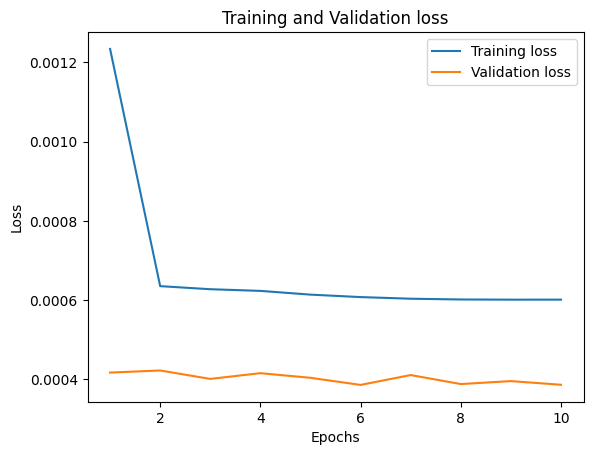

In [ ]:
import matplotlib.pyplot as plt

# define the training and validation loss lists


# create a range for the x-axis (epochs)
epochs = range(1, len(loss) + 1)

# plot the training and validation loss
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, test_loss, label='Validation loss')

# add titles and labels to the plot
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# display the plot
plt.show()

In [ ]:
target=[]
predict=[]
model.eval()
total_loss=0
with torch.no_grad():
        for X, y in test:
            
            target.append(y)
            output = model(X.unsqueeze(0))
            predict.append(output.item())
            total_loss += loss_function(output, y).item()
    
print(total_loss)        

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


158.33907063776212


In [ ]:
actual_values=target
predicted_values=predict

/usr/local/lib/python3.9/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.9/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


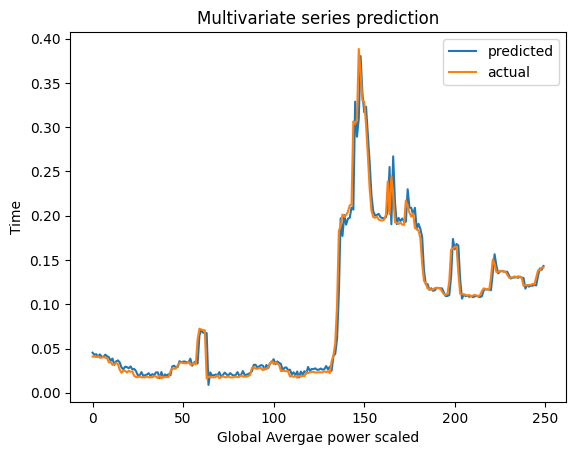

In [ ]:
import matplotlib.pyplot as plt
plt.plot(predicted_values[:250],label="predicted")
plt.plot(actual_values[:250],label="actual")
plt.title('Multivariate series prediction')
plt.xlabel('Global Avergae power scaled')
plt.ylabel('Time')
plt.legend()
plt.show()

## 70:30


In [ ]:
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv('household_power_consumption.txt', delimiter=';', 
                 parse_dates={'DateTime' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'])

# Drop rows with missing values
df.dropna(inplace=True)

# Convert data types of relevant columns
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], downcast='float')
df['Global_reactive_power'] = pd.to_numeric(df['Global_reactive_power'], downcast='float')
df['Voltage'] = pd.to_numeric(df['Voltage'], downcast='float')
df['Global_intensity'] = pd.to_numeric(df['Global_intensity'], downcast='float')



# Print the first few rows of the preprocessed DataFrame
df.head()

,DateTime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.839996,18.4,0.0,1.0,17.0
1,2006-12-16 17:25:00,5.360,0.436,233.630005,23.0,0.0,1.0,16.0
2,2006-12-16 17:26:00,5.374,0.498,233.289993,23.0,0.0,2.0,17.0
3,2006-12-16 17:27:00,5.388,0.502,233.740005,23.0,0.0,1.0,17.0
4,2006-12-16 17:28:00,3.666,0.528,235.679993,15.8,0.0,1.0,17.0


In [ ]:
df.set_index('DateTime', inplace=True)

In [ ]:
import matplotlib.pyplot as plt


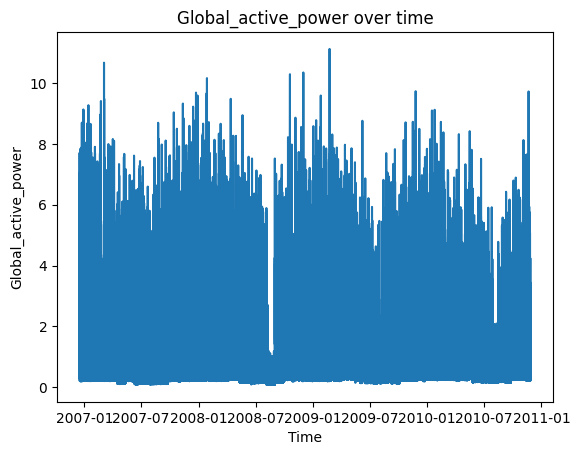

In [ ]:
plt.plot(df.Global_active_power)
plt.xlabel("Time")
plt.ylabel("Global_active_power")
plt.title("Global_active_power over time")
plt.savefig("initial_plot.png", dpi=1000)
plt.show();

In [ ]:
window_size=5

In [ ]:
def df_to_X_y2(df, window_size=6):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size][0]
    y.append(label)
  return np.array(X), np.array(y)

In [ ]:
X1, y1 = df_to_X_y2(df,window_size)
X1.shape, y1.shape

((2049275, 5, 7), (2049275,))

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()

#X_trans = ss.fit_transform(X1)
y1 = mm.fit_transform(y1.reshape(-1, 1))

In [ ]:
temp_training_mean = np.mean(X1[:, :, 0])
temp_training_std = np.std(X1[:, :, 0])
X1[:, :, 0] = (X1[:, :, 0] - temp_training_mean) / temp_training_std

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, data, targets):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.float32)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        return x, y

def numpy_to_dataset(data, targets):
    dataset = MyDataset(data, targets)
    #dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataset

In [ ]:
train = numpy_to_dataset(X1[:int(len(X1)*0.7)], y1[:int(len(X1)*0.7)])
test= numpy_to_dataset(X1[int(len(X1)*0.7):], y1[int(len(X1)*0.7):])

In [ ]:
batch_size = 64
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

y = y.view(-1)

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([64, 5, 7])
Target shape: torch.Size([64])


In [ ]:
from torch import nn

class ShallowRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.lstm = nn.LSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()

        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0]).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        return out

In [ ]:
class LSTM1(nn.Module):
    def __init__(self, num_sensors, hidden_units):
        super().__init__()
        self.lstm = nn.LSTM(num_sensors, hidden_units, batch_first=True)
        self.linear = nn.Linear(hidden_units, 1)

    def forward(self, x):
        h, _ = self.lstm(x)
        out = self.linear(h[:, -1])
        return out.squeeze()

In [ ]:
learning_rate = 5e-4
num_hidden_units = 8

model = LSTM1(num_sensors=7, hidden_units=num_hidden_units)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()

    for X, y in data_loader:
        y = y.view(-1)
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")
    return avg_loss

def test_model(data_loader, model, loss_function):

    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            y = y.view(-1)
            output = model(X)
    
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")
    return avg_loss


print("Untrained test\n--------")
test_model(test_loader, model, loss_function)
print()


loss=[]
test_loss=[]
for ix_epoch in range(10):
    print(f"Epoch {ix_epoch}\n---------")
    loss.append(train_model(train_loader, model, loss_function, optimizer=optimizer))
    test_loss.append(test_model(test_loader, model, loss_function))
    print()

Untrained test
--------
Train loss: 0.18311924281299918

Epoch 0
---------
Train loss: 0.00082200170025817
Train loss: 0.00046470041532134407

Epoch 1
---------
Train loss: 0.0005942066708799706
Train loss: 0.0004445052620242772

Epoch 2
---------
Train loss: 0.0005841840307721079
Train loss: 0.0004246734659131423

Epoch 3
---------
Train loss: 0.0005766753717994254
Train loss: 0.0004189338106351792

Epoch 4
---------
Train loss: 0.0005717860732779151
Train loss: 0.00041545419096534905

Epoch 5
---------
Train loss: 0.0005695056127176918
Train loss: 0.00042286863232286347

Epoch 6
---------
Train loss: 0.0005686142081004784
Train loss: 0.0004210545898703377

Epoch 7
---------
Train loss: 0.0005679534631972317
Train loss: 0.00043416095989903055

Epoch 8
---------
Train loss: 0.0005667418612228327
Train loss: 0.00041603397027768844

Epoch 9
---------
Train loss: 0.0005662870089878193
Train loss: 0.0004327955037714706



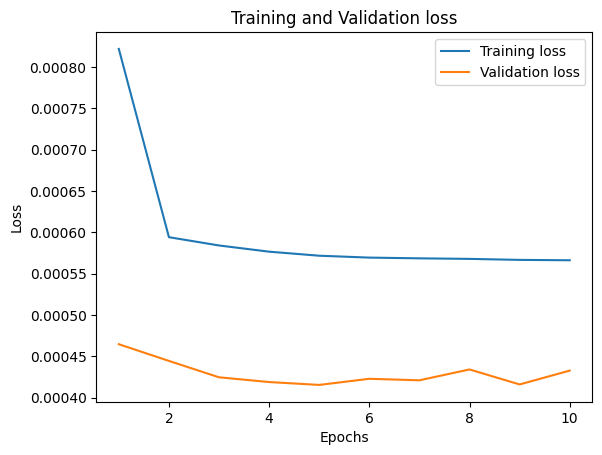

In [ ]:
import matplotlib.pyplot as plt

# define the training and validation loss lists


# create a range for the x-axis (epochs)
epochs = range(1, len(loss) + 1)

# plot the training and validation loss
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, test_loss, label='Validation loss')

# add titles and labels to the plot
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# display the plot
plt.show()

In [ ]:
target=[]
predict=[]
model.eval()
total_loss=0
with torch.no_grad():
        for X, y in test:
            
            target.append(y)
            output = model(X.unsqueeze(0))
            predict.append(output.item())
            total_loss += loss_function(output, y).item()
    
           

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [ ]:
total_loss

266.0752071085376

In [ ]:
actual_values=target
predicted_values=predict

/usr/local/lib/python3.9/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.9/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


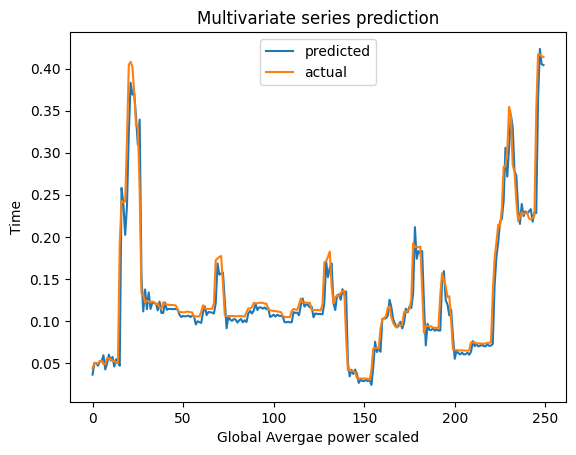

In [ ]:
import matplotlib.pyplot as plt
plt.plot(predicted_values[:250],label="predicted")
plt.plot(actual_values[:250],label="actual")
plt.title('Multivariate series prediction')
plt.xlabel('Global Avergae power scaled')
plt.ylabel('Time')
plt.legend()
plt.show()